In [1]:
! pip install transformers

     |████████████████████████████████| 890kB 2.5MB/s 
     |████████████████████████████████| 1.1MB 13.3MB/s 
     |████████████████████████████████| 3.0MB 18.6MB/s 
     |████████████████████████████████| 890kB 36.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ce35898b70de4bb0c61169a230828f431fd6962bd4d5d3e75c456c23c7d3c619
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pandas as pd
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils import data
from sklearn.model_selection import train_test_split
from models import BertSentimentClassifier
import numpy as np
import seaborn as sns
from collections import defaultdict

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [ ]:
df = pd.read_csv('reviews.csv')

In [ ]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
df = df[['content', 'score']]

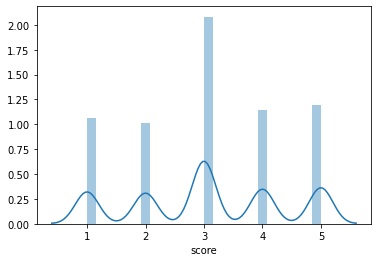

In [ ]:
sns.distplot(df.score)

In [ ]:
def score_to_sents(score):
    if score <= 2:
      return 0
    if score == 3:
      return 1
    return 2

In [ ]:
df['sentiment'] = df['score'].apply(score_to_sents)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
class ReviewsDataset(data.Dataset):
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self, item):
        review = str(self.review[item])
        enc = tokenizer.encode_plus(
            review,
            max_length=self.max_len,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt')
        
        return {'input_ids': enc['input_ids'].squeeze(0), 
                'attention_mask': enc['attention_mask'].squeeze(0),
                'targets': torch.tensor(self.target[item], dtype=torch.long)}

In [ ]:
lens = []
max_len = 0
for i in df.index:
  curr_len = len(tokenizer.encode(df.loc[i]['content']))
  lens.append(curr_len)
  max_len = max(curr_len, max_len)


In [ ]:
sns.distplot(lens)

In [ ]:
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 50

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
df_dev, df_test = train_test_split(df_test, test_size = 0.5, random_state=42)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = ReviewsDataset(
        review=df.content.to_numpy(),
        target=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)
    
    return data.DataLoader(dataset, batch_size=batch_size, num_workers=4)

In [ ]:
train_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
dev_loader = create_data_loader(df_dev, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
model = BertSentimentClassifier(n_classes=3).to(device)

### train

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)

criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
    model,
    data_loader,
    criterion,
    optimizer,
    scheduler,
    n_examples,
    device
):
    model.train()
    losses = []
    correct_preds = 0
    
    for i, d in enumerate(data_loader):
        if i % 50 == 0:
          print(f'batch {i + 1}/ {len(data_loader)}')
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, pred = torch.max(outputs, dim=1)
        
        loss = criterion(outputs, targets)
        correct_preds += torch.sum(pred == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_preds.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(
    model,
    data_loader,
    criterion,
    n_examples,
    device
):
    print('evaluation')
    model = model.eval()
    correct_preds = 0
    losses = []
    
    with torch.no_grad():
        for i, d in enumerate(data_loader):
            if i % 50 == 0:
              print(f'batch {i + 1}/ {len(data_loader)}')
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct_preds += torch.sum(pred == targets)
            losses.append(loss.item())
    return correct_preds.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_acc = 0

for epoch in range(EPOCHS):
    print(f'epoch: {epoch + 1}/{EPOCHS}')
    
    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        criterion,
        optimizer,
        scheduler,
        len(df_train),
        device
    )
    
    print(f'Train loss: {train_loss}, accuracy: {train_acc}')
    
    dev_acc, dev_loss = eval_model(
        model,
        dev_loader,
        criterion,
        len(df_dev),
        device
    )
    
    print(f'Train loss: {dev_loss}, accuracy: {dev_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['dev_acc'].append(dev_acc)
    history['dev_loss'].append(dev_loss)
    
    if dev_acc > best_acc:
        torch.save(model.state_dict(), 'model.pt')
        best_acc = dev_acc

In [ ]:
def eval_on_test(model_path, data_loader, n_examples):
  model = BertSentimentClassifier(3).to(device)
  model.load_state_dict(torch.load(model_path))
  model.eval()

  correct_preds = 0

  with torch.no_grad():
      for i, d in enumerate(data_loader):
            if i % 50 == 0:
              print(f'batch {i + 1}/ {len(data_loader)}')
          
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, pred = torch.max(outputs, dim=1)
            correct_preds += torch.sum(pred == targets)
  return correct_preds.double() / n_examples

In [ ]:
eval_on_test('model.pt', test_loader, len(df_test))